In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

You should consider upgrading via the 'c:\users\maria\violence-detection\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [ ]:
import os
import sys
import cv2
import zipfile
import numpy as np
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import svm
from sklearn.model_selection import train_test_split
from tensorflow_docs.vis import embed
from tensorflow import keras
from imutils import paths

In [ ]:
IMG_SIZE = 75
BATCH_SIZE = 64
EPOCHS = 10

MAX_SEQ_LENGTH = 15
NUM_FEATURES = 2048

In [ ]:
def load_videos(loc, max_frames=15, resize=(IMG_SIZE, IMG_SIZE)):
    frames = []
    for video_name in os.listdir(loc):
        video = cv2.VideoCapture(os.path.join(loc,video_name))
        new_packet = []
        i = 0
        while video.isOpened():
            ret, frame = video.read()
            if not ret:
                break
            if i % 4 != 0: # Works for 30 fps videos to capture only 15 fps
                i += 1
                continue
            frame = cv2.resize(frame, resize, interpolation = cv2.INTER_AREA)
            frame = frame[:, :, [2, 1, 0]] # RGB
            # frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            new_packet.append(frame)

            if len(new_packet) == max_frames:
                stacked = np.array(new_packet)/255.
                frames.append(stacked)
                new_packet.pop(0)
                # new_packet = np.array(new_packet)/255.
                # frames.append(new_packet)
                # new_packet = []
            i+=1
        video.release()
        if len(frames)>= 3000:
            break

    cv2.destroyAllWindows()
    frames = np.stack(frames, axis = 0)
    print(frames.shape)
    return frames # (instances_num, max_frames, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [ ]:
x_train_dir = 'D:\\ViolenceDetection\\Datasets\\LAD2000\\Violent_Excluded'

In [ ]:
encoding=os.listdir(x_train_dir)
label_processor =  keras.layers.experimental.preprocessing.StringLookup(
    num_oov_indices=0, vocabulary=encoding
)
print(label_processor.get_vocabulary())

['', 'Crash', 'Destroy', 'Drop', 'Fighting', 'Fire', 'Hurt', 'Thiefing', 'Trampled', 'Violence']


In [ ]:
x_train_data = []
for category in os.listdir(x_train_dir):
    cdir = f'{x_train_dir}\\{category}'
    x_train_data.append(load_videos(cdir, max_frames=15, resize= (IMG_SIZE, IMG_SIZE)))

(2009, 15, 75, 75, 3)
(3097, 15, 75, 75, 3)
(3093, 15, 75, 75, 3)
(3118, 15, 75, 75, 3)
(6271, 15, 75, 75, 3)
(2434, 15, 75, 75, 3)
(3167, 15, 75, 75, 3)
(3043, 15, 75, 75, 3)
(3142, 15, 75, 75, 3)


In [ ]:
y_train_data=[]
i = 0
for category in x_train_data:
    label=[encoding[i]] * len(category)
    y_train_data.append(label)
    i+=1

In [ ]:
[(x_train_data[i].shape, len(x_train_data[i])) for i in range(len(x_train_data))]

[((2009, 15, 75, 75, 3), 2009),
 ((3097, 15, 75, 75, 3), 3097),
 ((3093, 15, 75, 75, 3), 3093),
 ((3118, 15, 75, 75, 3), 3118),
 ((6271, 15, 75, 75, 3), 6271),
 ((2434, 15, 75, 75, 3), 2434),
 ((3167, 15, 75, 75, 3), 3167),
 ((3043, 15, 75, 75, 3), 3043),
 ((3142, 15, 75, 75, 3), 3142)]

In [ ]:
[len(y_train_data[i]) for i in range(len(y_train_data))]

[2009, 3097, 3093, 3118, 6271, 2434, 3167, 3043, 3142]

In [ ]:
x_train_data[0].shape, len(y_train_data[0])

((2009, 15, 75, 75, 3), 2009)

In [ ]:
x_train = np.concatenate(x_train_data)
y_train = np.concatenate(y_train_data)

In [ ]:
np.save('LAD_Data\\LAD_x_train_3000', x_train)
np.save('LAD_Data\\LAD_y_train_3000', y_train)

In [ ]:
del x_train_data
del y_train_data

In [ ]:
x_train = np.load('LAD_Data\\LAD_x_train_3000.npy')
y_train = np.load('LAD_Data\\LAD_y_train_3000.npy')

In [ ]:
x_train.shape , y_train.shape

((29374, 15, 75, 75, 3), (29374,))

In [ ]:
x_train, x_rem, y_train, y_rem = train_test_split(x_train, y_train,  train_size=0.7, shuffle = True, random_state=7)

In [ ]:
x_valid, x_test, y_valid, y_test = train_test_split(x_rem,y_rem, test_size=0.5, shuffle = True, random_state=7)

In [ ]:
np.save('LAD_Data\\y_test_3000.npy', y_test)

In [ ]:
def prepare_all(x_train, y_train):
    num_samples = len(x_train)
    labels = label_processor(y_train[..., None]).numpy()
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
          shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
      )
    for idx, packet in enumerate(x_train):
        frames = batch = packet         # (15, 75, 75, 3)
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_featutes = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )
        length = batch.shape[0]
        for j in range(length):
          temp_frame_featutes[0, j, :] = feature_extractor.predict(
                batch[None, j, :]       # (1, 100, 100, 3)
            )
        temp_frame_mask[0, :length] = 1  # 1 = not masked, 0 = masked
        frame_features[idx,] = temp_frame_featutes.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()
    return (frame_features, frame_masks), labels

train_data, train_labels = prepare_all(x_train, y_train)
val_data, val_labels = prepare_all(x_valid, y_valid)
test_data, test_labels = prepare_all(x_test, y_test)
print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")
print(f"Frame features in val set: {val_data[0].shape}")
print(f"Frame features in test set: {test_data[0].shape}")

Frame features in train set: (20561, 15, 2048)
Frame masks in train set: (20561, 15)
Frame features in val set: (4406, 15, 2048)
Frame features in test set: (4407, 15, 2048)


In [ ]:
np.save('LAD_Data\\train_data[0]_3000.npy', train_data[0])
np.save('LAD_Data\\train_data[1]_3000.npy', train_data[1])
np.save('LAD_Data\\val_data[0]_3000.npy', val_data[0])
np.save('LAD_Data\\val_data[1]_3000.npy', val_data[1])
np.save('LAD_Data\\test_data[0]_3000.npy', test_data[0])
np.save('LAD_Data\\test_data[1]_3000.npy', test_data[1])

In [ ]:
train_data = (np.load('LAD_Data\\train_data[0]_3000.npy'), np.load('LAD_Data\\train_data[1]_3000.npy'))
val_data = (np.load('LAD_Data\\val_data[0]_3000.npy'), np.load('LAD_Data\\val_data[1]_3000.npy'))
test_data = (np.load('LAD_Data\\test_data[0]_3000.npy'), np.load('LAD_Data\\test_data[1]_3000.npy'))
train_labels = label_processor(y_train[..., None]).numpy()
val_labels = label_processor(y_valid[..., None]).numpy()
test_labels = label_processor(y_test[..., None]).numpy()

In [ ]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    x = keras.layers.GRU(128, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(64)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(32, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam",
         metrics = ['accuracy']
    )
    return rnn_model

In [ ]:
def run_experiment():
    filepath = "C:\\Users\\Maria\\Violence-Detection\\venv\\Final_Classification\\Models\\LAD2000_Original"
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        batch_size = BATCH_SIZE,
        validation_data=([val_data[0], val_data[1]],
        val_labels),
        epochs=20,
        callbacks=[checkpoint]
    )

    seq_model.load_weights(filepath)
    loss, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model


history, sequence_model = run_experiment()

Epoch 1/20
322/322 [==============================] - 17s 35ms/step - loss: 1.7957 - accuracy: 0.3494 - val_loss: 1.4175 - val_accuracy: 0.4991

Epoch 00001: val_loss improved from inf to 1.41752, saving model to C:\Users\Maria\Violence-Detection\venv\Final_Classification\Models\LAD2000_Original
Epoch 2/20
322/322 [==============================] - 10s 30ms/step - loss: 1.3087 - accuracy: 0.5344 - val_loss: 1.0485 - val_accuracy: 0.6523

Epoch 00002: val_loss improved from 1.41752 to 1.04848, saving model to C:\Users\Maria\Violence-Detection\venv\Final_Classification\Models\LAD2000_Original
Epoch 3/20
322/322 [==============================] - 10s 30ms/step - loss: 1.0826 - accuracy: 0.6185 - val_loss: 0.8896 - val_accuracy: 0.6872

Epoch 00003: val_loss improved from 1.04848 to 0.88958, saving model to C:\Users\Maria\Violence-Detection\venv\Final_Classification\Models\LAD2000_Original
Epoch 4/20
322/322 [==============================] - 10s 30ms/step - loss: 0.9064 - accuracy: 0.6862

In [ ]:
sequence_model.save("C:\\Users\\Maria\\Violence-Detection\\venv\\Final_Classification\\Models\\LAD2000_Main_Excluded_93.92")

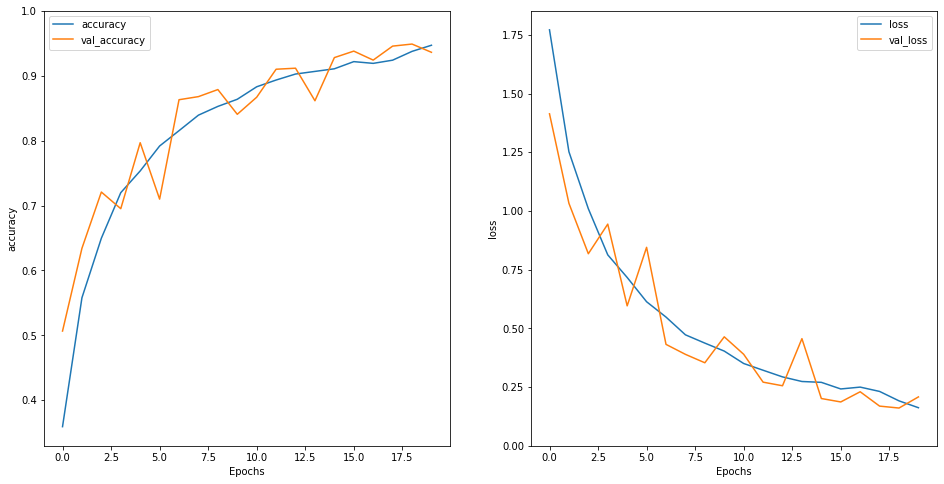

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)
plt.savefig('LAD_Data\\ACC_LOSS_Excluded_93.92.png')


# Confusion Matrix

In [ ]:
test_pred = sequence_model.predict([test_data[0], test_data[1]])
test_pred.shape, test_pred

((4407, 10),
 array([[7.84525866e-08, 6.58069330e-05, 9.03770924e-05, ...,
         9.99599397e-01, 1.07703845e-05, 2.44453586e-05],
        [4.81528105e-06, 2.85048168e-02, 8.54558125e-02, ...,
         6.80193678e-02, 1.92692925e-04, 1.96846738e-03],
        [2.84704238e-09, 5.41193174e-07, 3.50856135e-05, ...,
         1.30345186e-04, 1.46263756e-03, 9.98057902e-01],
        ...,
        [3.38105259e-08, 4.30751184e-04, 1.25798979e-04, ...,
         9.98968720e-01, 1.43755798e-07, 1.36954597e-07],
        [6.78035461e-10, 1.78910060e-08, 2.96075132e-06, ...,
         8.57652049e-06, 9.98786390e-01, 1.03706843e-03],
        [1.71966423e-08, 9.94013488e-01, 7.29122548e-05, ...,
         1.44880370e-03, 5.60288083e-09, 3.94218702e-09]], dtype=float32))

In [ ]:
class_vocab = label_processor.get_vocabulary()
class_vocab

['',
 'Crash',
 'Destroy',
 'Drop',
 'Fighting',
 'Fire',
 'Hurt',
 'Thiefing',
 'Trampled',
 'Violence']

In [ ]:
y_pred = []
for i in test_pred:
  for x in np.argsort(i)[::-1]:
    print(f"  {class_vocab[x]}: {i[x] * 100:5.2f}%")
    y_pred.append(class_vocab[x])
    break

  Thiefing: 99.96%
  Fighting: 71.46%
  Violence: 99.81%
  Thiefing: 99.99%
  Trampled: 95.38%
  Fire: 100.00%
  Destroy: 99.97%
  Trampled: 98.38%
  Fire: 99.94%
  Drop: 99.99%
  Destroy: 100.00%
  Fire: 99.61%
  Fire: 99.96%
  Fire: 99.99%
  Fire: 100.00%
  Violence: 70.73%
  Crash: 99.47%
  Trampled: 98.04%
  Fire: 99.94%
  Fighting: 63.95%
  Violence: 99.43%
  Fire: 100.00%
  Trampled: 99.87%
  Violence: 63.86%
  Fire: 100.00%
  Destroy: 38.35%
  Hurt: 92.38%
  Destroy: 87.72%
  Drop: 99.94%
  Drop: 99.96%
  Drop: 99.79%
  Violence: 98.51%
  Fire: 100.00%
  Violence: 88.79%
  Destroy: 99.97%
  Fighting: 30.52%
  Violence: 44.07%
  Fighting: 99.35%
  Trampled: 55.98%
  Fighting: 99.81%
  Fighting: 73.52%
  Thiefing: 99.99%
  Destroy: 99.98%
  Violence: 99.81%
  Fighting: 98.47%
  Fire: 100.00%
  Trampled: 99.50%
  Fighting: 99.26%
  Destroy: 99.55%
  Drop: 99.83%
  Trampled: 99.87%
  Crash: 99.84%
  Thiefing: 99.99%
  Violence: 99.21%
  Violence: 98.89%
  Crash: 99.93%
  Crash: 95.8

  Fire: 99.98%
  Crash: 91.09%
  Fighting: 59.34%
  Fire: 100.00%
  Thiefing: 99.99%
  Destroy: 99.57%
  Destroy: 99.98%
  Destroy: 99.98%
  Fire: 94.75%
  Drop: 99.96%
  Hurt: 77.59%
  Trampled: 91.53%
  Fighting: 99.08%
  Hurt: 79.96%
  Hurt: 97.93%
  Destroy: 99.97%
  Drop: 99.96%
  Drop: 99.91%
  Drop: 97.24%
  Trampled: 95.94%
  Violence: 99.69%
  Fire: 100.00%
  Thiefing: 99.99%
  Hurt: 99.64%
  Trampled: 96.37%
  Destroy: 98.68%
  Destroy: 82.00%
  Fighting: 99.36%
  Fighting: 97.40%
  Hurt: 61.09%
  Violence: 99.00%
  Drop: 99.38%
  Crash: 99.61%
  Destroy: 99.91%
  Destroy: 44.10%
  Fire: 99.99%
  Hurt: 60.67%
  Thiefing: 99.98%
  Trampled: 97.83%
  Trampled: 97.31%
  Destroy: 99.18%
  Fire: 99.99%
  Thiefing: 99.80%
  Fire: 100.00%
  Destroy: 99.99%
  Fire: 100.00%
  Destroy: 99.97%
  Trampled: 97.70%
  Fighting: 99.11%
  Fire: 90.04%
  Fire: 100.00%
  Violence: 99.82%
  Fighting: 97.31%
  Thiefing: 100.00%
  Thiefing: 100.00%
  Fighting: 99.76%
  Violence: 99.63%
  Drop: 99.

In [ ]:
y_pred = np.array(y_pred)
y_pred, y_pred.shape

(array(['Crowd', 'Trampled', 'Panic', ..., 'Trampled', 'Fire',
        'FallIntoWater'], dtype='<U13'),
 (3309,))

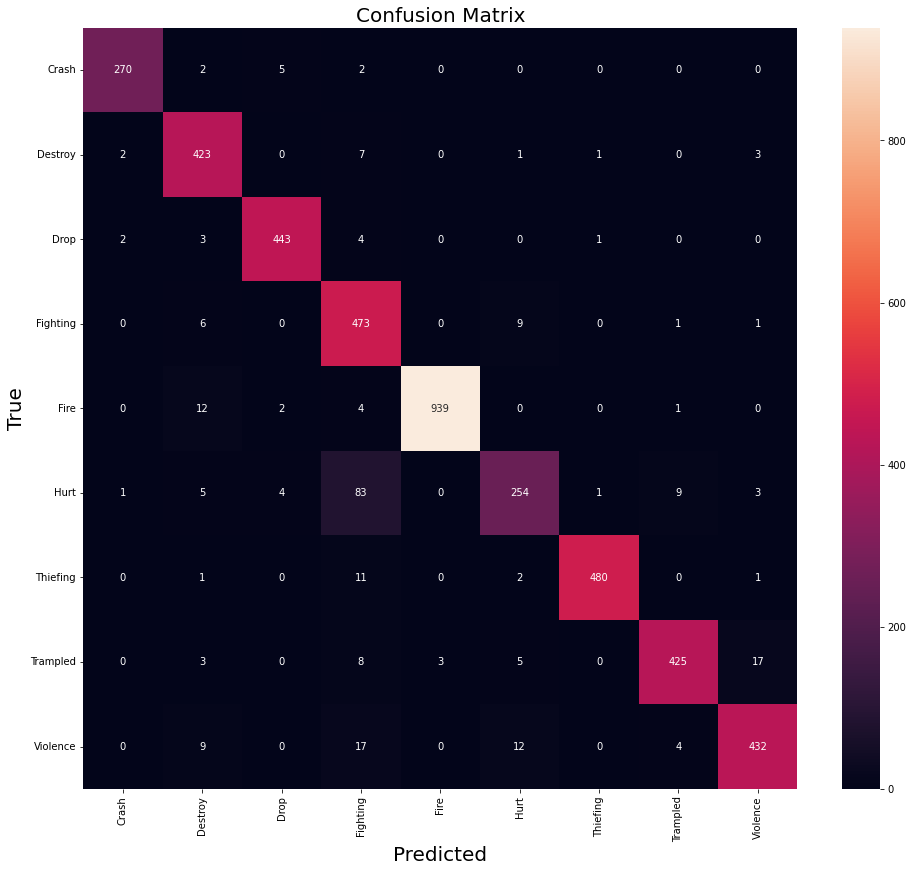

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
# cm = cm / cm.astype(np.float).sum(axis=1)

class_names = encoding

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Confusion Matrix', fontsize=20)

plt.savefig('LAD_Data\\ConMatExcluded_93.92.png')
plt.show()

# ROC

In [ ]:
plt.figure()
plt.subplot(111)
# plot no skill roc curve
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
# calculate roc curve for model
fpr, tpr, thresholds = roc_curve(test_labels, test_pred)
# plot model roc curve
plt.plot(fpr, tpr, marker='.', label='Logistic')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# plt.savefig("ROC_CURVE")

In [ ]:
roc_auc = roc_auc_score(test_labels, test_pred, multi_class = 'ovr')
print('Logistic ROC AUC %.3f' % roc_auc)

# Inference:


In [ ]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_featutes = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        print(i, batch, batch.shape)
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_featutes[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_featutes, frame_mask

def load_video(loc, max_frames=15, resize=(IMG_SIZE, IMG_SIZE)):
    frames = []
    video = cv2.VideoCapture(loc)
    new_packet = []
    i = 0
    while video.isOpened():
        ret, frame = video.read()
        if not ret:
            break
        if i % 2 != 0: # Works for 30 fps videos to capture only 15 fps
            i += 1
            continue
        frame = cv2.resize(frame, resize, interpolation = cv2.INTER_AREA)
        frame = frame[:, :, [2, 1, 0]] # RGB
        new_packet.append(frame)

        if len(new_packet) == max_frames:
            new_packet = np.array(new_packet)/255.
            frames.append(new_packet)
            new_packet = []
        i+=1
    video.release()

    cv2.destroyAllWindows()
    frames = np.stack(frames, axis = 0)
    # return frames # (instances_num, max_frames, IMG_SIZE, IMG_SIZE, 3)
    return frames[16]  # (max_frames, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
def sequence_prediction(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=5)
    return embed.embed_file("animation.gif")

In [ ]:
test_video_path = '/content/gdrive/MyDrive/DirectDownload/Anomaly-Videos-Part-4/Stealing/Stealing112_x264.mp4'
print(f"Test video path: {test_video_path}")
test_frames = sequence_prediction(test_video_path)
print(test_frames[:MAX_SEQ_LENGTH].shape. test_frames.shape)
to_gif(test_frames[:MAX_SEQ_LENGTH])